In [1]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

sqlEngine       = create_engine('mysql+pymysql://root:@127.0.0.1', pool_recycle=3600)
dbConnection    = sqlEngine.connect()
#data            = pd.read_sql("SELECT * FROM atx_traffic.tmsr WHERE origin_reader_identifier = 'benwhite_riverside' AND destination_reader_identifier = 'fm973_tx71';", dbConnection)

data            = pd.read_sql("SELECT * FROM atx_traffic.tmsr WHERE origin_reader_identifier = 'fm973_tx71' AND destination_reader_identifier = 'benwhite_riverside';", dbConnection)
#data            = pd.read_sql("SELECT * FROM atx_traffic.tmsr;", dbConnection)
#pd.set_option('display.expand_frame_repr', False)
#df
dbConnection.close()

In [2]:
df = data[['segment_length_miles','timestamp','average_travel_time_seconds','average_speed_mph','number_samples','standard_deviation']]

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'],infer_datetime_format=True)
df['time'] = df['timestamp'].dt.time
df['weekday'] = df['timestamp'].dt.weekday

In [4]:
df.set_index('timestamp',inplace=True)
df.sort_index(inplace=True)

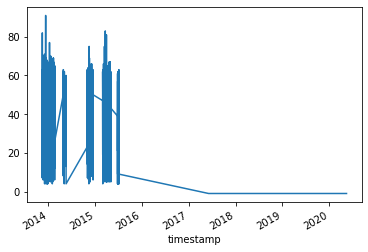

In [5]:
df.average_speed_mph.plot.line()

In [6]:
df = df[df.average_speed_mph != -1]

In [7]:
df['totalspeed'] = df.average_speed_mph * df.number_samples
df['totaltraveltime'] = df.average_travel_time_seconds * df.number_samples

In [8]:
df['pooled_variance'] = (df.number_samples - 1) * (df.standard_deviation) ** 2

In [9]:
df

,segment_length_miles,average_travel_time_seconds,average_speed_mph,number_samples,standard_deviation,time,weekday,totalspeed,totaltraveltime,pooled_variance
timestamp,,,,,,,,,,
2013-11-15 05:15:00,3.5,343,37,1,0.00,05:15:00,4,37,343,0.0000
2013-11-15 05:30:00,3.5,211,60,2,2.83,05:30:00,4,120,422,8.0089
2013-11-15 05:45:00,3.5,218,58,1,0.00,05:45:00,4,58,218,0.0000
2013-11-15 06:00:00,3.5,251,50,2,12.02,06:00:00,4,100,502,144.4804
2013-11-15 06:15:00,3.5,251,50,1,0.00,06:15:00,4,50,251,0.0000
...,...,...,...,...,...,...,...,...,...,...
2015-07-07 01:30:00,3.5,1428,9,1,0.00,01:30:00,1,9,1428,0.0000
2015-07-07 02:00:00,3.5,240,52,1,0.00,02:00:00,1,52,240,0.0000
2015-07-07 02:45:00,3.5,2865,4,1,0.00,02:45:00,1,4,2865,0.0000


In [10]:
#df.to_csv('benwhite_riverside-fm973_tx71.csv')
df.to_csv('fm973_tx71-benwhite_riverside.csv')

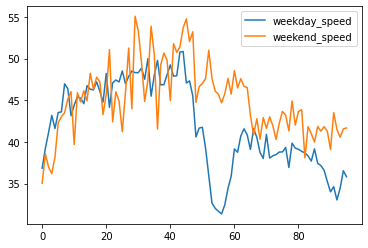

In [11]:
times = []
timechunks = []
weekday_num_samples = []
weekend_num_samples = []
weekday_speed = []
weekend_speed = []
weekday_travel_time = []
weekend_travel_time = []
weekday_pooled_sd_mph = []
weekend_pooled_sd_mph = []

timechunk = 0
for j in range(24):
    for i in range(4):
        df_temp_weekday = df[(df.time == dt.time(j,15*i)) & (df.weekday < 5)]
        weekday_speed.append(df_temp_weekday.totalspeed.sum() / df_temp_weekday.number_samples.sum())
        weekday_travel_time.append(df_temp_weekday.totaltraveltime.sum() / df_temp_weekday.number_samples.sum())
        weekday_pooled_sd_mph.append(df_temp_weekday.pooled_variance.sum()/(df_temp_weekday.number_samples.sum() - df_temp_weekday.shape[0]))
        weekday_num_samples.append(df_temp_weekday.number_samples.mean())

        df_temp_weekend = df[(df.time == dt.time(j,15*i)) & (df.weekday >= 5)]
        weekend_speed.append(df_temp_weekend.totalspeed.sum() / df_temp_weekend.number_samples.sum())
        weekend_travel_time.append(df_temp_weekend.totaltraveltime.sum() / df_temp_weekend.number_samples.sum())
        weekend_pooled_sd_mph.append(df_temp_weekend.pooled_variance.sum()/(df_temp_weekend.number_samples.sum() - df_temp_weekend.shape[0]))
        weekend_num_samples.append(df_temp_weekend.number_samples.mean())

        timechunks.append(timechunk)
        timechunk += 1
        times.append(dt.time(j,15*i))
plt.plot(timechunks, weekday_speed, label = 'weekday_speed')
plt.plot(timechunks, weekend_speed, label = 'weekend_speed')
plt.legend()
plt.show()

In [12]:
df_timechunk = pd.DataFrame(list(
    zip(times,
    timechunks,
    weekday_num_samples,
    weekend_num_samples,
    weekday_speed,
    weekend_speed,
    weekday_travel_time,
    weekend_travel_time,
    weekday_pooled_sd_mph,
    weekend_pooled_sd_mph)), columns=[
    'time',
    'timechunk',
    'weekday_num_samples',
    'weekend_num_samples',
    'weekday_speed',
    'weekend_speed',
    'weekday_travel_time',
    'weekend_travel_time',
    'weekday_pooled_sd_mph',
    'weekend_pooled_sd_mph'
])

In [13]:
df_timechunk

,time,timechunk,weekday_num_samples,weekend_num_samples,weekday_speed,weekend_speed,weekday_travel_time,weekend_travel_time,weekday_pooled_sd_mph,weekend_pooled_sd_mph
0,00:00:00,0,6.598540,7.372549,36.838496,35.039894,386.316372,501.207447,96.029856,73.661957
1,00:15:00,1,6.835714,7.934783,39.226750,38.564384,357.566353,410.408219,93.669574,47.352607
2,00:30:00,2,6.457143,8.021277,41.132743,36.973475,336.818584,414.973475,101.406820,84.920306
3,00:45:00,3,5.543478,7.804348,43.179085,36.189415,320.015686,469.749304,93.257261,69.921421
4,01:00:00,4,5.793651,6.460000,41.608219,38.201238,351.943836,405.696594,119.683472,82.372826
...,...,...,...,...,...,...,...,...,...,...
91,22:45:00,91,7.798658,7.102041,34.617040,43.528736,418.797762,305.600575,67.793313,61.384469
92,23:00:00,92,7.315068,7.943396,33.031835,41.484561,460.251873,326.204276,80.620226,75.750762
93,23:15:00,93,7.420690,6.562500,34.431227,40.568254,442.725836,360.320635,65.293457,75.876510
94,23:30:00,94,7.695364,7.215686,36.534423,41.559783,412.451807,340.956522,57.117938,86.190619


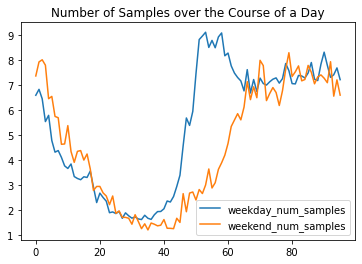

In [18]:
plt.plot(timechunks, weekday_num_samples, label = 'weekday_num_samples')
plt.plot(timechunks, weekend_num_samples, label = 'weekend_num_samples')
plt.legend()
plt.title('Number of Samples over the Course of a Day')
plt.show()

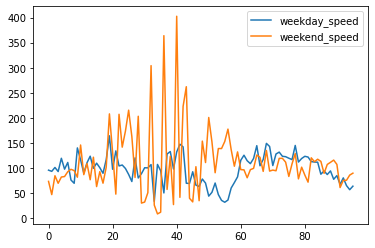

In [15]:
plt.plot(timechunks, weekday_pooled_sd_mph, label = 'weekday_speed')
plt.plot(timechunks, weekend_pooled_sd_mph, label = 'weekend_speed')
plt.legend()
plt.show()

In [16]:
df.average_speed_mph / df.average_travel_time_seconds

timestamp
2013-11-15 05:15:00    0.107872
2013-11-15 05:30:00    0.284360
2013-11-15 05:45:00    0.266055
2013-11-15 06:00:00    0.199203
2013-11-15 06:15:00    0.199203
                         ...   
2015-07-07 01:30:00    0.006303
2015-07-07 02:00:00    0.216667
2015-07-07 02:45:00    0.001396
2015-07-07 04:00:00    0.215768
2015-07-07 04:30:00    0.006334
Length: 15193, dtype: float64

In [17]:
df_timechunk.to_csv('fm973_tx71-benwhite_riverside-timechunks.csv', index=False)